In [1]:
# data processing, CSV and image I/O
import os
import re
import requests
from PIL import Image
import pandas as pd
import numpy  as np

# libraries for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#preprocessing, modeling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

C:\Users\Om Patel\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print(tf.__version__)

2.14.0


In [3]:
# set random seed
tf.random.set_seed(42)
np.random.seed(42)

## Data Loading

In [6]:
main_path = 'chest_xray'
os.listdir(main_path)

['test', 'train', 'val']

In [7]:
train_dir = os.path.join(main_path, 'train')
test_dir = os.path.join(main_path, 'test')
val_dir = os.path.join(main_path, 'val')

In [8]:
def count_file(dir=None, labels=None):
    for label in labels:
        num_data = len(os.listdir(os.path.join(dir, label)))
        print(f'count {label} : {num_data}')
        
labels = ['PNEUMONIA', 'NORMAL']

print('train:')
count_file(train_dir,labels)
print('\n')
print("test:")
count_file(test_dir,labels)
print('\n')
print("validation:")
count_file(val_dir,labels)

train:
count PNEUMONIA : 3875
count NORMAL : 1341


test:
count PNEUMONIA : 390
count NORMAL : 234


validation:
count PNEUMONIA : 8
count NORMAL : 8


##### We can see that there is imbalance in our dataset

In [9]:
def get_file_sizes(directory):
    file_sizes = []
    
    for root,dirs,files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            size = os.path.getsize(file_path)/1024 #bytes to KB
            file_sizes.append({'file':file_path, 'size_kb':round(size,3)})
    return file_sizes          

In [10]:
get_file_sizes(val_dir)[:12]

[{'file': 'chest_xray\\val\\NORMAL\\NORMAL2-IM-1427-0001.jpeg',
  'size_kb': 247.197},
 {'file': 'chest_xray\\val\\NORMAL\\NORMAL2-IM-1430-0001.jpeg',
  'size_kb': 256.556},
 {'file': 'chest_xray\\val\\NORMAL\\NORMAL2-IM-1431-0001.jpeg',
  'size_kb': 244.524},
 {'file': 'chest_xray\\val\\NORMAL\\NORMAL2-IM-1436-0001.jpeg',
  'size_kb': 242.994},
 {'file': 'chest_xray\\val\\NORMAL\\NORMAL2-IM-1437-0001.jpeg',
  'size_kb': 208.734},
 {'file': 'chest_xray\\val\\NORMAL\\NORMAL2-IM-1438-0001.jpeg',
  'size_kb': 166.883},
 {'file': 'chest_xray\\val\\NORMAL\\NORMAL2-IM-1440-0001.jpeg',
  'size_kb': 517.72},
 {'file': 'chest_xray\\val\\NORMAL\\NORMAL2-IM-1442-0001.jpeg',
  'size_kb': 464.008},
 {'file': 'chest_xray\\val\\PNEUMONIA\\person1946_bacteria_4874.jpeg',
  'size_kb': 59.686},
 {'file': 'chest_xray\\val\\PNEUMONIA\\person1946_bacteria_4875.jpeg',
  'size_kb': 57.868},
 {'file': 'chest_xray\\val\\PNEUMONIA\\person1947_bacteria_4876.jpeg',
  'size_kb': 61.275},
 {'file': 'chest_xray\\val

####Next, we will create a dataframe to make it easier for us to analyze the image size and distribution of each class.   

In [11]:
def create_dataframe(path, labels):
    data = []
    for label in labels:
        category_path = os.path.join(path, label)
        file_sizes = get_file_sizes(category_path)
        data.extend(file_sizes)
        
    df = pd.DataFrame(data)
    return df

In [12]:
train_df = create_dataframe(train_dir,labels)
test_df = create_dataframe(test_dir,labels)
val_df = create_dataframe(val_dir,labels)

print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 2)
shape of test_dir (624, 2)
shape of val_dir (16, 2)


In [13]:
#

In [14]:
val_df

,file,size_kb
0,chest_xray\val\PNEUMONIA\person1946_bacteria_4...,59.686
1,chest_xray\val\PNEUMONIA\person1946_bacteria_4...,57.868
2,chest_xray\val\PNEUMONIA\person1947_bacteria_4...,61.275
3,chest_xray\val\PNEUMONIA\person1949_bacteria_4...,96.932
4,chest_xray\val\PNEUMONIA\person1950_bacteria_4...,84.569
5,chest_xray\val\PNEUMONIA\person1951_bacteria_4...,48.116
6,chest_xray\val\PNEUMONIA\person1952_bacteria_4...,85.525
7,chest_xray\val\PNEUMONIA\person1954_bacteria_4...,116.825
8,chest_xray\val\NORMAL\NORMAL2-IM-1427-0001.jpeg,247.197
9,chest_xray\val\NORMAL\NORMAL2-IM-1430-0001.jpeg,256.556


In [15]:
print('shape of val_dir',val_df.shape)

shape of val_dir (16, 2)


In [16]:
def extract_label(file_path):
    if 'PNEUMONIA' in file_path:
        return 'pneumonia'
    elif 'NORMAL' in file_path:
        return 'normal'
    else:
        return 'unknown'
    
dict_dir_df = {'train': train_df,
              'test': test_df,
              'val': val_df}

In [17]:
for df in dict_dir_df.values():
    df['label'] = df['file'].apply(extract_label)

In [18]:
train_df.sample(3)

,file,size_kb,label
1897,chest_xray\train\PNEUMONIA\person299_bacteria_...,33.954,pneumonia
877,chest_xray\train\PNEUMONIA\person1415_virus_24...,126.712,pneumonia
4503,chest_xray\train\NORMAL\NORMAL2-IM-0416-0001-0...,511.034,normal


###We can see that the images from the dataset only have 2 dimensions, namely height and width. So we can consider this data as gray scale.

In [19]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 3)
shape of test_dir (624, 3)
shape of val_dir (16, 3)


In [20]:
def get_image_dimensions(file_path):  # To get size of image
    try:
        with Image.open(file_path) as img:
            return img.size
    except Exception as e:
        print(f"Error reading image {file_path}: {e}")
        return (0, 0)

In [21]:
for name, df in dict_dir_df.items():
    df['dimensions'] = df['file'].apply(get_image_dimensions)

In [22]:
# Filter only rows with 'dimensionality' greater than equal 3
for name, df in dict_dir_df.items():
    filtered_dir = df[df['dimensions'].apply(lambda x: len(x) >= 3)]
    print(f'{name}:',filtered_dir.shape[0])

train: 0
test: 0
val: 0


In [23]:
train_df.sample(3)

,file,size_kb,label,dimensions
318,chest_xray\train\PNEUMONIA\person116_virus_221...,120.850,pneumonia,"(1728, 1168)"
4221,chest_xray\train\NORMAL\IM-0527-0001.jpeg,464.512,normal,"(1728, 1175)"
5028,chest_xray\train\NORMAL\NORMAL2-IM-1152-0001-0...,573.450,normal,"(1636, 1433)"


In [24]:
print('shape of train_dir',train_df.shape)
print('shape of test_dir',test_df.shape)
print('shape of val_dir',val_df.shape)

shape of train_dir (5216, 4)
shape of test_dir (624, 4)
shape of val_dir (16, 4)


In [25]:
#The validation data has a small amount, namely 16 images. Therefore, we will combine the data with train, val and test data then split the data with a ratio of 70:15:15, 70% for train data, 15% for validation data and 15% for the test set.
merged_df = pd.concat([train_df, val_df,test_df], ignore_index=True)
merged_df.shape

(5856, 4)

In [26]:
train_df, test_df_full = train_test_split(merged_df, test_size=0.3, 
                                    stratify = merged_df['label'], random_state=42)

test_df, val_df = train_test_split(test_df_full, test_size=0.5, 
                                    stratify = test_df_full['label'], random_state=42)

In [27]:
print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(4099, 4)
(878, 4)
(879, 4)


### Data Preprocessing

In [28]:
def preprocess_image(file_path, label, channels=3):
    # Read image files
    img = tf.io.read_file(file_path)
    
    # Decoding images into tensors
    img = tf.image.decode_jpeg(img, channels=channels)
    
    # Resize the image according to your model's needs
    img = tf.image.resize(img, [224, 224])  
    
    # Normalize pixel values to range [0, 1]
    img = tf.cast(img, tf.float32) / 255.0  
    
    # Convert labels to numeric (0 for normal, 1 for pneumonia)
    # label = tf.cond(tf.math.equal(label, tf.constant('normal')), lambda: 0, lambda: 1)
    label = tf.where(tf.math.equal(label, 'normal'), 0, 1)
    
    
    return img, label

##### Next, we will see the results of the augmentation when using color_jitter, whether the augmentation is worth using or whether it makes the model worse. If we want to do color_jitter we need to set channels=3.

In [29]:
def color_jitter(image, brightness_factor=0.01, contrast_factor=0.01, seed=None):
    image = tf.image.random_brightness(image, max_delta=0.1, seed=seed)
    image = tf.image.random_contrast(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_saturation(image, lower=1-contrast_factor, upper=1+contrast_factor, seed=seed)
    image = tf.image.random_hue(image, max_delta=0.1, seed=seed)
    
    return image

In [30]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


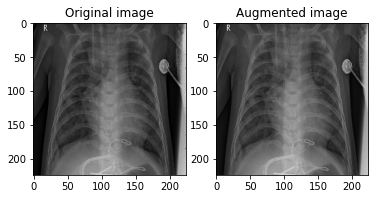

In [31]:
image_path = 'chest_xray/train/PNEUMONIA/person1180_virus_2010.jpeg'
img, label = preprocess_image(image_path,'pneumonia',channels=3)
color_jiter_test = color_jitter(img,seed=3)
visualize(img, color_jiter_test)

In [32]:
img.shape

TensorShape([224, 224, 3])

In [33]:
number = train_df.shape[0]
factors = []

# Loop to find dividing factors
for i in range(1, number + 1):
    if number % i == 0:
        factors.append(i)

# Print the dividing factors
print("Dividing factors of", number, "is:", factors)

Dividing factors of 4099 is: [1, 4099]


In [34]:
# Constants for automatic improvement of dataset performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Batch size for model training
batch_size = 32

Notes:

AUTOTUNE: Constant used to enable automatic enhancement of dataset performance. This allows TensorFlow to automatically adjust configurations to maximize speed and efficiency in dataset processing.

batch_size: The batch size to be used in model training. A batch is a number of data samples processed simultaneously in one training iteration. A batch size of 32 means 32 data samples will be processed at once in each training iteration. Batch size can affect training speed and memory usage.

In [35]:
# Augmentation function for train data
def augment_train_image(img, label):
    # Add augmentations according to your needs
#     o
    img= color_jitter(img, seed=3)
    return img, label

# Augmentation function for val data
def augment_val_image(img, label):
    # Add augmentations as needed
    return img, label

layers_augmentation = tf.keras.Sequential([
            #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
            tf.keras.layers.RandomRotation(0.02),
            tf.keras.layers.RandomZoom(height_factor=(0.05, 0.1),width_factor=(0.05, 0.1)),
        ])

In layers_augmentation we set Random Zoom and Random Rotation to small values so that the resulting image appears clear and so that the model can recognize the image pattern well.

In [36]:
def prepare(ds, batch_size=32,shuffle=False, layers_aug=False, custom_aug=False):
    # Map preprocess_image function ke dataset
    ds = ds.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    ds = ds.cache()
    
    if shuffle:
        ds = ds.shuffle(buffer_size=1000)
        

    if custom_aug:
        ds = ds.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    if layers_aug:
        ds = ds.map(lambda x, y: (layers_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    ds = ds.batch(batch_size)
    ds = ds.prefetch(AUTOTUNE)

    return ds

Information:

The function above is a function for preparing datasets with tf.data and for optimizing the preprocessing process and training process in parallel. This is useful so that when training the model it is faster, especially when using a GPU.
ds.cache(): Saves dataset into cache. This can improve performance by avoiding rereading data from the source every time a new epoch starts. However, keep in mind that caching can require significant memory space depending on the size of the dataset.
If the shuffle parameter is set as True, then the dataset will be shuffled. This is useful for ensuring that the model does not memorize data sequences and can more effectively learn common patterns.
ds.batch(batch_size): Splits the dataset into batches with the size specified by the batch_size parameter. Batches are used in model training to perform batch-based optimization.
ds.prefetch(AUTOTUNE): Uses prefetching to load the next batch into memory while training the model on the current batch. This can increase the efficient use of CPU and GPU time.

In [37]:
# Create a train dataset using tf.data.Dataset.from_tensor_slices
train_image_paths = train_df['file'].values
train_labels = train_df['label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths, train_labels))
# train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.map(augment_train_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dataset = train_dataset.batch(batch_size)
# train_ds = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)
train_ds= prepare(train_dataset, batch_size, shuffle=False, custom_aug=True)

# Create dataset val
val_dataset = tf.data.Dataset.from_tensor_slices((val_df['file'].values, val_df['label'].values))
val_ds = prepare(val_dataset,batch_size, shuffle=False)

# Create dataset test
test_dataset = tf.data.Dataset.from_tensor_slices((test_df['file'].values, test_df['label'].values))
test_ds = prepare(test_dataset, batch_size, shuffle=False)

In [38]:
# Example of iteration through the train dataset
for images, labels in train_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (32, 224, 224, 3)
Batch Size: 32
Labels: [1 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1]


In the code above, if it is run repeatedly, the label value will change because we are using shuffle

In [39]:
# Example of iteration through the train dataset
for images, labels in val_ds.take(1):
    print(f"Batch of images shape: {images.shape}")
    print(f"Batch Size: {images.shape[0]}")
    print(f"Labels: {labels}")

Batch of images shape: (32, 224, 224, 3)
Batch Size: 32
Labels: [1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0]


In [40]:
for images, labels in train_ds.take(1):
    print(images[0,:,:,0])

tf.Tensor(
[[0.06176034 0.07088909 0.08119404 ... 0.04157278 0.05422962 0.07923245]
 [0.06176034 0.06962511 0.07680523 ... 0.06695426 0.06497335 0.04295951]
 [0.06176034 0.06836113 0.07109973 ... 0.04831237 0.05463302 0.05456293]
 ...
 [0.02742219 0.03804317 0.02636889 ... 0.02636889 0.03804347 0.02742133]
 [0.02636889 0.02636889 0.02636889 ... 0.02636889 0.02636889 0.02636889]
 [0.02636889 0.02636889 0.02636889 ... 0.02636889 0.02636889 0.02636889]], shape=(224, 224), dtype=float32)


Notes:

images: A tensor (possibly from image data) with at least four dimensions (batch size, width, height, color channel).

[0, :, :, 0]: This is an indexing operation. This section details that we want to retrieve the element from the tensor at the first position in the batch dimension (index 0), retrieve the entire image width (axis 1), the entire image height (axis 2), and only the first channel (index 0) of the color channels.
In the context of a grayscale image, [:, :, 0] means we are only taking the first channel of the image (grayscale only has one channel).

Example: If images is a tensor of shape (64, 200, 200, 3) (64 images, each with size 200x200 pixels and 3 RGB color channels), then images[0, :, :, 0] will take up the entire width and the image height of the first image and only the first (red) channel of that image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

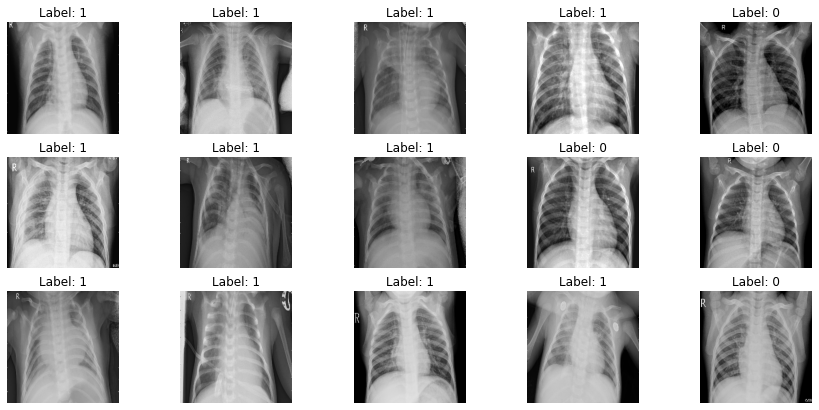

In [41]:
# Take a batch from the dataset
for images, labels in train_ds.take(1):
    # Visualization of some images from the first batch
    plt.figure(figsize=(15, 7))
    for i in range(15):
        plt.subplot(3, 5, i + 1)  # Change the subplot parameters to 3 rows and 5 columns
        #plt.imshow(images[i, :, :, 0], cmap='gray') 
        plt.imshow(images[i])
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis('off')
    plt.show()

#### Transfer Leraning VGG16

In [41]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

Notes:

Global Average Pooling is a technique used to reduce the spatial dimensions of data. In this case, for each "channel" of data, we only have one average value. This helps reduce the number of parameters in the model and prevents overfitting, while retaining relevant information.

In [42]:
input_shape= (224, 224, 3)

In [66]:
# Take it model VGG16 pre-trained
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Build a new model on top of the VGG16 model
model_4 = tf.keras.Sequential()
model_4.add(base_model)
#model_4.add(GlobalAveragePooling2D())
model_4.add(Flatten())
model_4.add(Dense(198, activation='relu'))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.2))
model_4.add(Dense(1, activation='sigmoid'))

# Set the pre-trained model layer so that it cannot be re-trained
for layer in base_model.layers:
    layer.trainable = False

In [43]:
model_4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 198)               4967622   
                                                                 
 dense_1 (Dense)             (None, 128)               25472     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19707911 (75.18 MB)
Trainable params: 49

In the model above we use flatten(), because after testing, even though it produces overfit, the score on the test is better when using flatten() compared to GlobalAveragePooling2D().

In [67]:
# Set the learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model_4.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In the transfer learning model we will try to set a higher or faster learning rate compared to previous models.

In [68]:
checkpoint_filepath4 = './tmp/checkpoint4'
checkpoint_dir4 = os.path.dirname(checkpoint_filepath4)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath4, monitor='val_loss',mode='min', 
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [69]:
history_4= model_4.fit(train_ds, validation_data=val_ds, 
            epochs=10, 
            callbacks=callbacks_1, verbose=1)


Epoch 1/10
129/129 [==============================] - 521s 4s/step - loss: 0.8134 - accuracy: 0.9151 - val_loss: 0.2153 - val_accuracy: 0.9215 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 498s 4s/step - loss: 0.1230 - accuracy: 0.9539 - val_loss: 0.1457 - val_accuracy: 0.9454 - lr: 0.0100
Epoch 3/10
129/129 [==============================] - 530s 4s/step - loss: 0.0865 - accuracy: 0.9710 - val_loss: 0.1203 - val_accuracy: 0.9636 - lr: 0.0100
Epoch 4/10
129/129 [==============================] - 529s 4s/step - loss: 0.0665 - accuracy: 0.9790 - val_loss: 0.1441 - val_accuracy: 0.9579 - lr: 0.0100
Epoch 5/10
129/129 [==============================] - 501s 4s/step - loss: 0.0504 - accuracy: 0.9824 - val_loss: 0.1921 - val_accuracy: 0.9499 - lr: 0.0100
Epoch 6/10
129/129 [==============================] - 497s 4s/step - loss: 0.0311 - accuracy: 0.9890 - val_loss: 0.1128 - val_accuracy: 0.9670 - lr: 0.0020
Epoch 7/10
129/129 [==============================] - 486s 4s/st

In [45]:
def train_val_eval(history_name=None):
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    return train_loss, val_loss, train_acc, val_acc

In [80]:
def plot_training_history(history_name=None,start_epoch=1):
    # Pastikan history_name tidak None
    if history_name is None:
        raise ValueError("Parameter 'history_name' harus diisi dengan objek riwayat (history).")

    # Ambil data pelatihan dari objek history
    train_loss, val_loss, train_acc, val_acc=train_val_eval(history_name)
    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))
    learning_rate = history_name.history['lr']
    

    # Buat plot untuk loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss',marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss',marker='x',color='blue')
    plt.plot(range_epoch, learning_rate, label='learning_rate',marker='*',color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    # Buat plot untuk accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy',marker='o',color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy',marker='x',color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch) 
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))


    plt.show()

In [47]:
def evaluate(data=None, model=None):
    loss, acc = model.evaluate(data, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    print("Restored model, loss: {:5.2f}%".format(100 * loss))

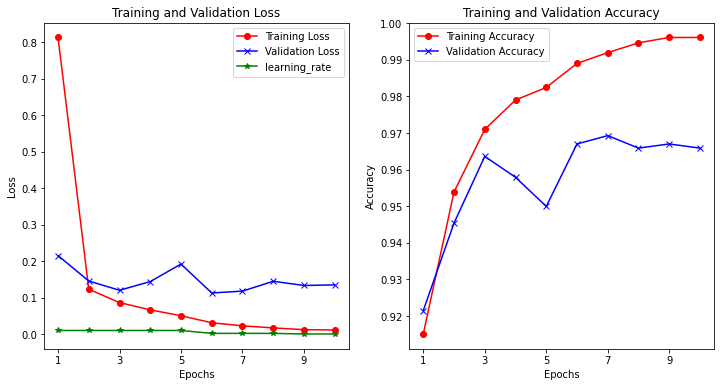

In [79]:
plot_training_history(history_name=history_4)

In [71]:
model_4.load_weights(checkpoint_filepath4)

evaluate(val_ds,model_4)

28/28 - 79s - loss: 0.1128 - accuracy: 0.9670 - 79s/epoch - 3s/step
Restored model, accuracy: 96.70%
Restored model, loss: 11.28%


In [ ]:
evaluate(train_ds,model_4)

In [ ]:
evaluate(test_ds,model_4)

In [52]:
model_4.save('model_4.keras')

In [53]:
model_4.save('model_4_h5.h5')

C:\Users\Om Patel\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [47]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.


In [41]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model

In [42]:
saved_model = load_model('model_4.keras')

In [43]:
saved_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 198)               4967622   
                                                                 
 dense_1 (Dense)             (None, 128)               25472     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 19707911 (75.18 MB)
Trainable params: 49

In [48]:
evaluate(val_ds,saved_model)

28/28 - 198s - loss: 0.1182 - accuracy: 0.9647 - 198s/epoch - 7s/step
Restored model, accuracy: 96.47%
Restored model, loss: 11.82%


In [49]:
json_string = saved_model.to_json()

In [50]:
saved_model.save_weights('model_4_weights.h5')

### ResNet

In [1]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D

In [54]:
# Take it model Resnet50 pre-trained
rn50_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Build a new model on top of the VGG16 model
model_5 = tf.keras.Sequential()
model_5.add(rn50_model)
#model_4.add(GlobalAveragePooling2D())
model_5.add(Flatten())
model_5.add(Dense(198, activation='relu'))
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.2))
model_5.add(Dense(1, activation='sigmoid'))

# Set the pre-trained model layer so that it cannot be re-trained
for layer in rn50_model.layers:
    layer.trainable = False

In [55]:
rn50_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 56, 56, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 56, 56, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 56, 56, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 28, 28, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 28, 28, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 28, 28, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 14, 14, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 14, 14, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 14, 14, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 14, 14, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 14, 14, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 14, 14, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 14, 14, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 7, 7, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 7, 7, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 7, 7, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [57]:
# Set the learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model_5.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
checkpoint_filepath_rn50 = './tmp/checkpoint_rn50'
checkpoint_dir4 = os.path.dirname(checkpoint_filepath_rn50)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath_rn50, monitor='val_loss',mode='min', 
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [59]:
history_5= model_5.fit(train_ds, validation_data=val_ds, 
            epochs=10, 
            callbacks=callbacks_1, verbose=1)

Epoch 1/10
129/129 [==============================] - 240s 2s/step - loss: 5.3494 - accuracy: 0.7260 - val_loss: 0.5056 - val_accuracy: 0.7281 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 227s 2s/step - loss: 0.4466 - accuracy: 0.7995 - val_loss: 0.4452 - val_accuracy: 0.7713 - lr: 0.0100
Epoch 3/10
129/129 [==============================] - 223s 2s/step - loss: 0.3997 - accuracy: 0.8226 - val_loss: 0.4479 - val_accuracy: 0.7509 - lr: 0.0100
Epoch 4/10
129/129 [==============================] - 245s 2s/step - loss: 0.3683 - accuracy: 0.8502 - val_loss: 0.3855 - val_accuracy: 0.8146 - lr: 0.0100
Epoch 5/10
129/129 [==============================] - 256s 2s/step - loss: 0.3586 - accuracy: 0.8509 - val_loss: 0.3821 - val_accuracy: 0.8077 - lr: 0.0100
Epoch 6/10
129/129 [==============================] - 253s 2s/step - loss: 0.3320 - accuracy: 0.8609 - val_loss: 0.4412 - val_accuracy: 0.8032 - lr: 0.0100
Epoch 7/10
129/129 [==============================] - 263s 2s/st

In [58]:
def train_val_eval(history_name=None):
    train_loss = history_name.history['loss']
    val_loss = history_name.history['val_loss']
    train_acc = history_name.history['accuracy']
    val_acc = history_name.history['val_accuracy']
    return train_loss, val_loss, train_acc, val_acc

In [75]:
def plot_training_history(history_name=None,start_epoch=1):
    # Pastikan history_name tidak None
    if history_name is None:
        raise ValueError("Parameter 'history_name' harus diisi dengan objek riwayat (history).")

    # Ambil data pelatihan dari objek history
    train_loss, val_loss, train_acc, val_acc=train_val_eval(history_name)
    range_epoch= np.arange(start_epoch, start_epoch + len(train_loss))
    learning_rate = history_name.history['lr']
    

    # Buat plot untuk loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range_epoch, train_loss, label='Training Loss',marker='o', color='red')
    plt.plot(range_epoch, val_loss, label='Validation Loss',marker='x',color='blue')
    plt.plot(range_epoch, learning_rate, label='learning_rate',marker='*',color='green')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))

    # Buat plot untuk accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range_epoch, train_acc, label='Training Accuracy',marker='o',color='red')
    plt.plot(range_epoch, val_acc, label='Validation Accuracy',marker='x',color='blue')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xticks(range_epoch) 
    plt.xticks(np.arange(start_epoch, start_epoch + len(train_loss), step=2))
    
    plt.savefig('fig4.png',dpi=200)
    
    plt.show()

In [53]:
def evaluate(data=None, model=None):
    loss, acc = model.evaluate(data, verbose=2)
    print("Restored model, accuracy: {:5.2f}%".format(100 * acc))
    print("Restored model, loss: {:5.2f}%".format(100 * loss))

In [60]:
model_5.load_weights(checkpoint_filepath_rn50)

evaluate(val_ds,model_5)

28/28 - 43s - loss: 0.2772 - accuracy: 0.8908 - 43s/epoch - 2s/step
Restored model, accuracy: 89.08%
Restored model, loss: 27.72%


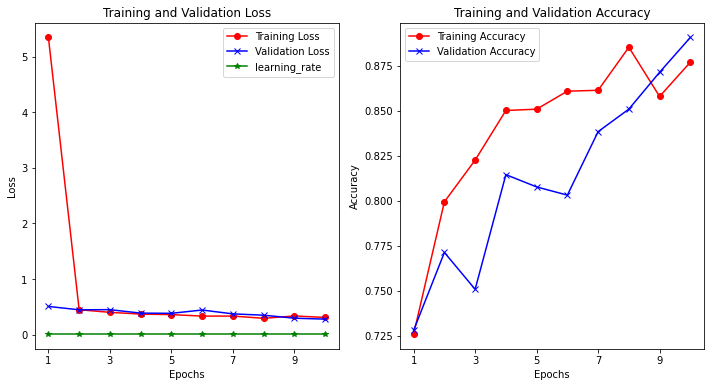

In [81]:
plot_training_history(history_name=history_5)

In [64]:
model_5.save('model_5_h5.h5')

C:\Users\Om Patel\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### DenseNet

In [4]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D

In [43]:
input_shape= (224, 224, 3)

In [45]:
# Take it model DenseNet121 pre-trained
dn121_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# Build a new model on top of the VGG16 model
model_6 = tf.keras.Sequential()
model_6.add(dn121_model)
#model_4.add(GlobalAveragePooling2D())
model_6.add(Flatten())
model_6.add(Dense(198, activation='relu'))
model_6.add(Dense(128, activation='relu'))
model_6.add(Dropout(0.2))
model_6.add(Dense(1, activation='sigmoid'))

# Set the pre-trained model layer so that it cannot be re-trained
for layer in dn121_model.layers:
    layer.trainable = False

In [46]:
dn121_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 230, 230, 3)          0         ['input_2[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 112, 112, 64)         9408      ['zero_padding2d_2[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, 56, 56, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 56, 56, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 56, 56, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 56, 56, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 28, 28, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 28, 28, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 28, 28, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 28, 28, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 28, 28, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 14, 14, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 14, 14, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 14, 14, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 14, 14, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 14, 14, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 14, 14, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 14, 14, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 14, 14, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 14, 14, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 14, 14, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 14, 14, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 14, 14, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 14, 14, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 14, 14, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 14, 14, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 14, 14, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 14, 14, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 14, 14, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 14, 14, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 14, 14, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 pool4_bn (BatchNormalizati  (None, 14, 14, 1024)         4096      ['conv4_block24_concat[0][0]']
 on)      

 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 7, 7, 608)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 7, 7, 128)            77824     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block4_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
          

 conv5_block8_0_bn (BatchNo  (None, 7, 7, 736)            2944      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 7, 7, 736)            0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 7, 7, 128)            94208     ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block8_1_bn (BatchNo  (None, 7, 7, 128)            512       ['conv5_block8_1_conv[0][0]'] 
 rmalizati

                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 7, 7, 864)            3456      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 7, 7, 864)            0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 7, 7, 128)            110592    ['conv5_block12_0_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_blo

 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 7, 7, 992)            3968      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 7, 7, 992)            0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block16_1_conv (Conv  (None, 7, 7, 128)            126976    ['conv5_block16_0_relu[0][0]']
 2D)                                                                                              
          

In [48]:
# Set the learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model_6.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [49]:
checkpoint_filepath_dn121 = './tmp/checkpoint_dn121'
checkpoint_dir6 = os.path.dirname(checkpoint_filepath_dn121)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath_dn121, monitor='val_loss',mode='min', 
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [50]:
history_6= model_6.fit(train_ds, validation_data=val_ds, 
            epochs=10, 
            callbacks=callbacks_1, verbose=1)

Epoch 1/10
129/129 [==============================] - 300s 2s/step - loss: 5.3464 - accuracy: 0.8951 - val_loss: 0.1798 - val_accuracy: 0.9511 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 248s 2s/step - loss: 0.1348 - accuracy: 0.9517 - val_loss: 0.1380 - val_accuracy: 0.9545 - lr: 0.0100
Epoch 3/10
129/129 [==============================] - 249s 2s/step - loss: 0.1016 - accuracy: 0.9636 - val_loss: 0.1289 - val_accuracy: 0.9636 - lr: 0.0100
Epoch 4/10
129/129 [==============================] - 248s 2s/step - loss: 0.0824 - accuracy: 0.9690 - val_loss: 0.1077 - val_accuracy: 0.9636 - lr: 0.0100
Epoch 5/10
129/129 [==============================] - 251s 2s/step - loss: 0.0920 - accuracy: 0.9737 - val_loss: 0.1153 - val_accuracy: 0.9647 - lr: 0.0100
Epoch 6/10
129/129 [==============================] - 248s 2s/step - loss: 0.0520 - accuracy: 0.9805 - val_loss: 0.1254 - val_accuracy: 0.9704 - lr: 0.0100
Epoch 7/10
129/129 [==============================] - 248s 2s/st

In [54]:
model_6.load_weights(checkpoint_filepath_dn121)

evaluate(val_ds,model_6)

28/28 - 42s - loss: 0.1077 - accuracy: 0.9636 - 42s/epoch - 2s/step
Restored model, accuracy: 96.36%
Restored model, loss: 10.77%


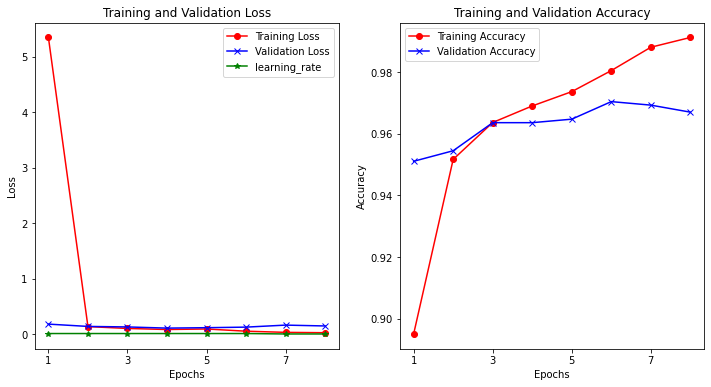

In [57]:
plot_training_history(history_name=history_6)

In [61]:
model_6.save('model_6.keras')

### Xception

In [62]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import GlobalAveragePooling2D

In [63]:
input_shape= (224, 224, 3)

In [64]:
# Take it model Xception pre-trained
xc_model = Xception(weights='imagenet', include_top=False, input_shape=input_shape)

# Build a new model on top of the VGG16 model
model_7 = tf.keras.Sequential()
model_7.add(xc_model)
#model_4.add(GlobalAveragePooling2D())
model_7.add(Flatten())
model_7.add(Dense(198, activation='relu'))
model_7.add(Dense(128, activation='relu'))
model_7.add(Dropout(0.2))
model_7.add(Dense(1, activation='sigmoid'))

# Set the pre-trained model layer so that it cannot be re-trained
for layer in xc_model.layers:
    layer.trainable = False

83683744/83683744 [==============================] - 10s 0us/step


In [65]:
xc_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 111, 111, 32)         864       ['input_3[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 111, 111, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 111, 111, 32)         0         ['block1_conv1_bn[0][0]

                                                                                                  
 block4_sepconv2_act (Activ  (None, 28, 28, 728)          0         ['block4_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block4_sepconv2 (Separable  (None, 28, 28, 728)          536536    ['block4_sepconv2_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block4_sepconv2_bn (BatchN  (None, 28, 28, 728)          2912      ['block4_sepconv2[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 conv2d_2 

                                                                                                  
 block7_sepconv1 (Separable  (None, 14, 14, 728)          536536    ['block7_sepconv1_act[0][0]'] 
 Conv2D)                                                                                          
                                                                                                  
 block7_sepconv1_bn (BatchN  (None, 14, 14, 728)          2912      ['block7_sepconv1[0][0]']     
 ormalization)                                                                                    
                                                                                                  
 block7_sepconv2_act (Activ  (None, 14, 14, 728)          0         ['block7_sepconv1_bn[0][0]']  
 ation)                                                                                           
                                                                                                  
 block7_se

 ormalization)                                                                                    
                                                                                                  
 add_7 (Add)                 (None, 14, 14, 728)          0         ['block9_sepconv3_bn[0][0]',  
                                                                     'add_6[0][0]']               
                                                                                                  
 block10_sepconv1_act (Acti  (None, 14, 14, 728)          0         ['add_7[0][0]']               
 vation)                                                                                          
                                                                                                  
 block10_sepconv1 (Separabl  (None, 14, 14, 728)          536536    ['block10_sepconv1_act[0][0]']
 eConv2D)                                                                                         
          

 block12_sepconv3_act (Acti  (None, 14, 14, 728)          0         ['block12_sepconv2_bn[0][0]'] 
 vation)                                                                                          
                                                                                                  
 block12_sepconv3 (Separabl  (None, 14, 14, 728)          536536    ['block12_sepconv3_act[0][0]']
 eConv2D)                                                                                         
                                                                                                  
 block12_sepconv3_bn (Batch  (None, 14, 14, 728)          2912      ['block12_sepconv3[0][0]']    
 Normalization)                                                                                   
                                                                                                  
 add_10 (Add)                (None, 14, 14, 728)          0         ['block12_sepconv3_bn[0][0]', 
          

In [71]:
checkpoint_filepath_xc= './tmp/checkpoint_xc'
checkpoint_dir7 = os.path.dirname(checkpoint_filepath_xc)

callbacks_1 = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_filepath_xc, monitor='val_loss',mode='min', 
                    save_weights_only=True, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-7)
]

In [72]:
# Set the learning rate
learning_rate = 0.01  # dafault 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Compile the model with the optimizer
model_7.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [73]:
history_7= model_7.fit(train_ds, validation_data=val_ds, 
            epochs=10, 
            callbacks=callbacks_1, verbose=1)

Epoch 1/10
129/129 [==============================] - 241s 2s/step - loss: 0.3210 - accuracy: 0.8992 - val_loss: 0.1957 - val_accuracy: 0.9340 - lr: 0.0100
Epoch 2/10
129/129 [==============================] - 240s 2s/step - loss: 0.1983 - accuracy: 0.9039 - val_loss: 0.2479 - val_accuracy: 0.8908 - lr: 0.0100
Epoch 3/10
129/129 [==============================] - 241s 2s/step - loss: 0.1313 - accuracy: 0.9497 - val_loss: 0.4600 - val_accuracy: 0.9170 - lr: 0.0100
Epoch 4/10
129/129 [==============================] - 241s 2s/step - loss: 0.0786 - accuracy: 0.9717 - val_loss: 0.3168 - val_accuracy: 0.9431 - lr: 0.0020
Epoch 5/10
129/129 [==============================] - 242s 2s/step - loss: 0.0460 - accuracy: 0.9822 - val_loss: 0.2312 - val_accuracy: 0.9556 - lr: 0.0020


In [74]:
model_7.load_weights(checkpoint_filepath_xc)

evaluate(val_ds,model_7)

28/28 - 38s - loss: 0.1957 - accuracy: 0.9340 - 38s/epoch - 1s/step
Restored model, accuracy: 93.40%
Restored model, loss: 19.57%


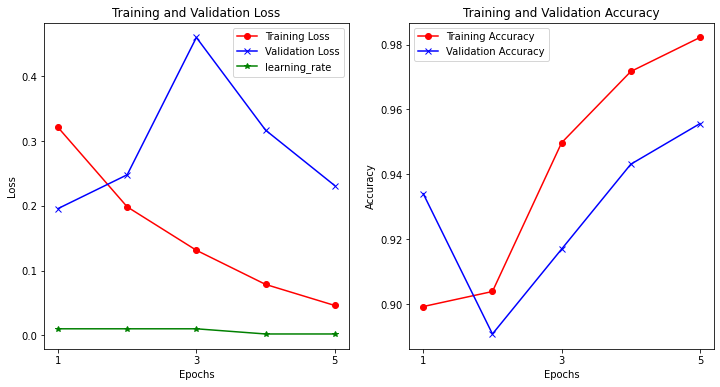

In [76]:
plot_training_history(history_name=history_7)

In [78]:
model_7.save('model_7_h5.h5')

C:\Users\Om Patel\anaconda3\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
